In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# STEP 1: Load CSV files
# =======================
train_csv = pd.read_csv("Training_set.csv")
test_csv = pd.read_csv("Testing_s" \
"" \
"" \
"et.csv")

print("✅ Training data shape:", train_csv.shape)
print("✅ Testing data shape:", test_csv.shape)
print(train_csv.head())

# If the CSV has columns like 'filename' and 'label', check them
print("Columns:", train_csv.columns)


✅ Training data shape: (6499, 2)
✅ Testing data shape: (2786, 1)
      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART
Columns: Index(['filename', 'label'], dtype='object')


In [4]:
train_dir = "train"
test_dir = "test"

print("Checking folders...")
print("Train folder exists:", os.path.exists(train_dir))
print("Test folder exists:", os.path.exists(test_dir))


Checking folders...
Train folder exists: True
Test folder exists: True


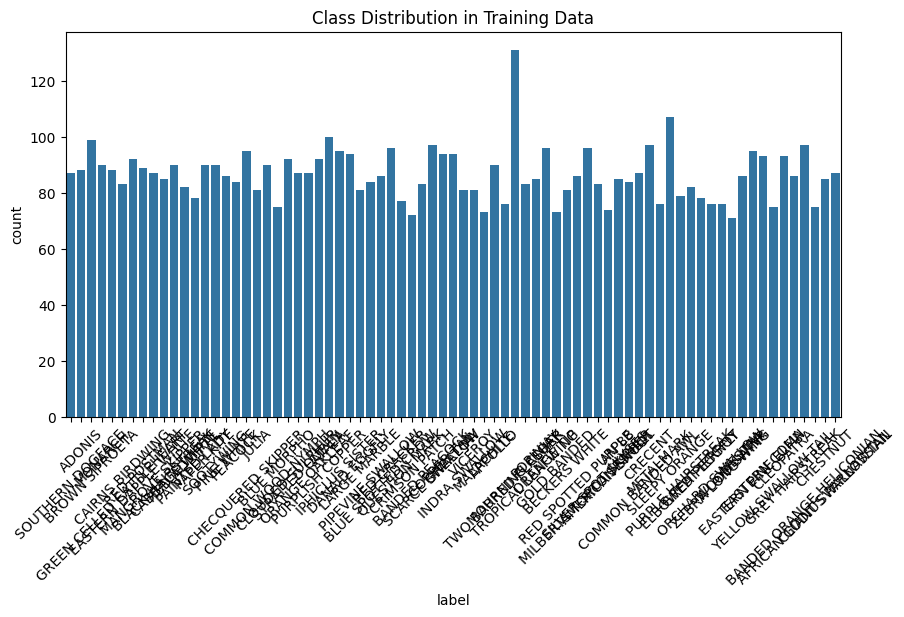

Total unique classes: 75


In [5]:
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=train_csv)
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=45)
plt.show()

print("Total unique classes:", train_csv['label'].nunique())


In [6]:
# STEP 5: Image Generators
# ========================
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    subset='training',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    subset='validation',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_csv,
    directory=test_dir,
    x_col='filename',
    target_size=(128,128),
    batch_size=32,
    class_mode=None,
    shuffle=False
)


Found 5200 validated image filenames belonging to 75 classes.
Found 1299 validated image filenames belonging to 75 classes.
Found 2786 validated image filenames.


In [7]:
# STEP 6: Build CNN Model
# ========================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Use class_indices length instead of num_classes
    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\CNN\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,314,315 (12.64 MB)

 Trainable params: 3,314,315 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ========================
# STEP 7: Train the Model
# ========================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 669ms/step - accuracy: 0.0196 - loss: 4.2935 - val_accuracy: 0.0485 - val_loss: 4.1118
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 225ms/step - accuracy: 0.0858 - loss: 3.8325 - val_accuracy: 0.2356 - val_loss: 3.2328
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.1877 - loss: 3.1420 - val_accuracy: 0.3780 - val_loss: 2.5468
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 244ms/step - accuracy: 0.2925 - loss: 2.6588 - val_accuracy: 0.4280 - val_loss: 2.2143
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - accuracy: 0.3642 - loss: 2.3172 - val_accuracy: 0.4742 - val_loss: 2.0382
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.4306 - loss: 2.0031 - val_accuracy: 0.5112 - val_loss: 1.8498
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 258ms/step - accuracy: 0.4850 - loss: 1.7537 - val_accuracy: 0.5327 - val_loss: 1.7832
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.5360 - loss: 

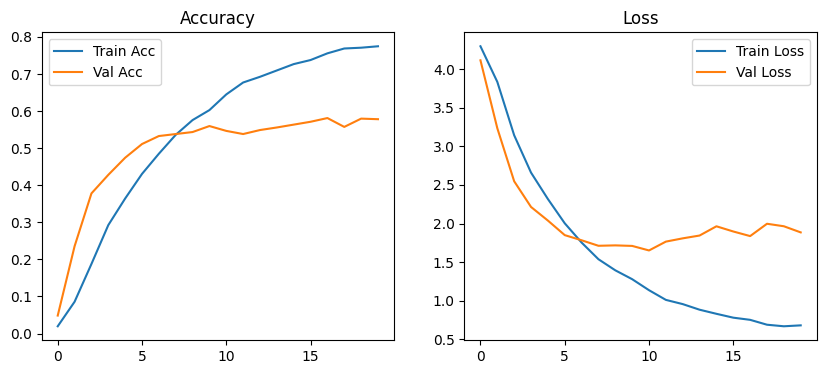

In [9]:
# STEP 8: Plot Accuracy & Loss
# ========================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

In [11]:
# ========================
# STEP 9: Evaluate on Validation Set (Precision, Recall, F1)
# ========================
val_gen.reset()
val_preds = model.predict(val_gen)
val_pred_classes = np.argmax(val_preds, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("\n📊 Classification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step

📊 Classification Report:


NameError: name 'classification_report' is not defined

In [12]:
# ========================
# STEP 10: Save the Model
# ========================
model.save("butterfly_cnn_model.h5")
print("✅ Model saved as butterfly_cnn_model.h5")

✅ Model saved as butterfly_cnn_model.h5
